In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import chart_studio
from collections import Counter
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ModuleNotFoundError: ignored

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
project_data = pd.read_csv('/content/drive/My Drive/6_Donors_choose_NB/train_data.csv')

In [11]:
project_data.head(5)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Math & Science,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1


In [12]:
teacher_prefixL=project_data['teacher_prefix'].values
teacher_prefixL=list(teacher_prefixL)
cleanedteacher_prefixL = [x for x in project_data['teacher_prefix'] if x != float('nan')] ## Cleaning the nan Values in the list -> https://stackoverflow.com/a/50297200/4433839
len(cleanedteacher_prefixL)

109248

In [13]:

project_data.dropna(subset=['teacher_prefix'], inplace=True)  ##https://stackoverflow.com/a/29314880/4433839
project_data.shape #(reduced 3 columns containing nan values)

(109245, 17)

Data Preprocessing step

In [0]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


In [0]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

In [0]:
# this code removes " " and "-". ie Grades 3-5 -> grage3to5
#  remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
clean_grades=[]
for project_grade in project_data['project_grade_category'].values:
    project_grade=str(project_grade).lower().strip().replace(' ','').replace('-','to')
    
    clean_grades.append(project_grade.strip())

project_data['clean_project_grade_category']=clean_grades
project_data.drop(['project_grade_category'],axis=1,inplace=True)

my_counter = Counter()
for word in project_data['clean_project_grade_category'].values:
    my_counter.update(word.split())
    
grade_dict = dict(my_counter)
sorted_project_grade_cat_dict = dict(sorted(grade_dict.items(), key=lambda kv: kv[1]))

In [0]:
# merging essays column : text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [18]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,clean_project_grade_category,essay
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,gradesprekto2,My students are English learners that are work...
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,grades6to8,Our students arrive to our school eager to lea...


In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [21]:
# removing unwanted symbols , space etc from essay column therby making it more meaningful for our data model
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109245/109245 [01:01<00:00, 1764.48it/s]


In [0]:
## adding processed essay and removing unprocessed essay
project_data['preprocessed_essays'] = preprocessed_essays
project_data.drop(['essay'], axis=1, inplace=True)

In [23]:
preprocessed_essays[50000]

'students potential world need help acquiring adequate resources facilitate success students always excited energetic engaged music class soak every concept like sponge ask interesting questions never give would love see students able play instruments together compose music fully immersed every facet music e music class addition obvious musical benefits extra resources allow students activities make well rounded individuals overall not music classroom music classroom currently minimal number available resources small budget shared elementary music middle school choir middle school high school band able obtain materials elementary classroom make sure students musically interested literate secondary programs continue grow addition resources classroom k 5 students able challenge not understand concept able apply concept real physical way students able work together make actual music perform level comprehension increase opportunity solidify learned class learn perseverance determination pa

In [24]:
# similarly preprocessing the titles column
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|██████████| 109245/109245 [00:02<00:00, 41341.77it/s]


In [0]:
project_data['preprocessed_titles'] = preprocessed_titles

In [28]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories',
       'clean_project_grade_category', 'preprocessed_essays',
       'preprocessed_titles'],
      dtype='object')

Splitting data step

In [29]:
#dividing the whole dataset into the ratio of (train:test) = 80:20 
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(project_data,project_data['project_is_approved'],test_size=0.2,random_state=42,stratify=project_data[['project_is_approved']])
print("x_train: ",x_train.shape)
print("x_test : ",x_test.shape)
print("y_train: ",y_train.shape)
print("y_test : ",y_test.shape)

x_train:  (87396, 19)
x_test :  (21849, 19)
y_train:  (87396,)
y_test :  (21849,)


Vectorization Step

In [30]:
# using CountVectorizer to convert the features into one hot encoding 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_sub = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_sub.fit(x_train['clean_categories'].values)
x_train_categories_one_hot = vectorizer_sub.transform(x_train['clean_categories'].values)
x_test_categories_one_hot  = vectorizer_sub.transform(x_test['clean_categories'].values)

print(vectorizer_sub.get_feature_names())
print("Shape of matrix after one hot encoding: x_train: ",x_train_categories_one_hot.shape)
print("Shape of matrix after one hot encoding: x_test : ",x_test_categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encoding: x_train:  (87396, 9)
Shape of matrix after one hot encoding: x_test :  (21849, 9)


In [33]:
vectorizer_sub_sub = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_sub_sub.fit(x_train['clean_subcategories'].values)
x_train_sub_categories_one_hot = vectorizer_sub_sub.transform(x_train['clean_subcategories'].values)
x_test_sub_categories_one_hot  = vectorizer_sub_sub.transform(x_test['clean_subcategories'].values)

print(vectorizer_sub_sub.get_feature_names())
print("Shape of matrix after one hot encoding: x_train: ",x_train_sub_categories_one_hot.shape)
print("Shape of matrix after one hot encoding: x_test : ",x_test_sub_categories_one_hot.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encoding: x_train:  (87396, 30)
Shape of matrix after one hot encoding: x_test :  (21849, 30)


In [0]:
my_counter = Counter()
for state in project_data['school_state'].values:
    my_counter.update(state.split())
school_state_cat_dict = dict(my_counter)
sorted_school_state_cat_dict = dict(sorted(school_state_cat_dict.items(), key=lambda kv: kv[1]))

In [35]:
#https://stackoverflow.com/questions/8955448/save-load-scipy-sparse-csr-matrix-in-portable-data-format
from scipy import sparse 
statelist=list(project_data['school_state'].values)
vectorizer_state = CountVectorizer(vocabulary=set(statelist), lowercase=False, binary=True)
vectorizer_state.fit(x_train['school_state'])
x_train_school_state_one_hot = vectorizer_state.transform(x_train['school_state'].values)
x_test_school_state_one_hot  = vectorizer_state.transform(x_test['school_state'].values)

print(vectorizer_state.get_feature_names())
print("Shape of matrix after one hot encoding: x_train: ",x_train_school_state_one_hot.shape)
print("Shape of matrix after one hot encoding: x_test : ",x_test_school_state_one_hot.shape)

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
Shape of matrix after one hot encoding: x_train:  (87396, 51)
Shape of matrix after one hot encoding: x_test :  (21849, 51)


In [0]:
my_counter = Counter()
for teacher_prefix in project_data['teacher_prefix'].values:
    teacher_prefix = str(teacher_prefix).lower().replace('.','').strip()
    my_counter.update(teacher_prefix.split())

teacher_prefix_cat_dict = dict(my_counter)
sorted_teacher_prefix_cat_dict = dict(sorted(teacher_prefix_cat_dict.items(), key=lambda kv: kv[1]))

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_prefix = CountVectorizer(vocabulary=list(sorted_teacher_prefix_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_prefix.fit(x_train['teacher_prefix'].values)
x_train_prefix_one_hot = vectorizer_prefix.transform(x_train['teacher_prefix'].values)
x_test_prefix_one_hot  = vectorizer_prefix.transform(x_test['teacher_prefix'].values)

print(vectorizer_prefix.get_feature_names())
print("Shape of matrix after one hot encoding: x_train: ",x_train_prefix_one_hot.shape)
print("Shape of matrix after one hot encoding: x_test : ",x_test_prefix_one_hot.shape)

['dr', 'teacher', 'mr', 'ms', 'mrs']
Shape of matrix after one hot encoding: x_train:  (87396, 5)
Shape of matrix after one hot encoding: x_test :  (21849, 5)


In [38]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_grade = CountVectorizer(vocabulary=list(sorted_project_grade_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_grade.fit(x_train['clean_project_grade_category'].values)
x_train_grade_category_one_hot = vectorizer_grade.transform(x_train['clean_project_grade_category'].values)
x_test_grade_category_one_hot  = vectorizer_grade.transform(x_test['clean_project_grade_category'].values)

print(vectorizer_grade.get_feature_names())
print("Shape of matrix after one hot encoding: x_train : ",x_train_grade_category_one_hot.shape)
print("Shape of matrix after one hot encoding: x_test  : ",x_test_grade_category_one_hot.shape)


['grades9to12', 'grades6to8', 'grades3to5', 'gradesprekto2']
Shape of matrix after one hot encoding: x_train :  (87396, 4)
Shape of matrix after one hot encoding: x_test  :  (21849, 4)


In [39]:
x_train_grade_category_one_hot.toarray()

array([[0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

In [41]:
from sklearn.preprocessing import StandardScaler
teacher_previous_proj_normalizer = Normalizer()
teacher_previous_proj_normalizer.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)) # finding the mean and standard deviation of this data
x_train_teacher_previous_proj_normalized = teacher_previous_proj_normalizer.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(1,- 1)).reshape(-1,1)
x_test_teacher_previous_proj_normalized  = teacher_previous_proj_normalizer.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(1,- 1)).reshape(-1,1)

print("Shape of matrix after normalization: x_train:  ",x_train_prefix_one_hot.shape)
print("Shape of matrix after normalization: x_test :  ",x_test_prefix_one_hot.shape)


Shape of matrix after normalization: x_train:   (87396, 5)
Shape of matrix after normalization: x_test :   (21849, 5)


BOW part

In [42]:
vectorizer_essay_bow = CountVectorizer(min_df=10)
vectorizer_essay_bow.fit(x_train['preprocessed_essays'])
x_train_essays_bow = vectorizer_essay_bow.transform(x_train['preprocessed_essays'])
x_test_essays_bow  = vectorizer_essay_bow.transform(x_test['preprocessed_essays'])

print("Shape of matrix after BOW -> Essays: x_train: ",x_train_essays_bow.shape)
print("Shape of matrix after BOW -> Essays: x_test : ",x_test_essays_bow.shape)

Shape of matrix after BOW -> Essays: x_train:  (87396, 15167)
Shape of matrix after BOW -> Essays: x_test :  (21849, 15167)


In [43]:
vectorizer_title_bow = CountVectorizer(min_df=10)
vectorizer_title_bow.fit(x_train['preprocessed_titles'])
x_train_titles_bow = vectorizer_title_bow.transform(x_train['preprocessed_titles'])
x_test_titles_bow  = vectorizer_title_bow.transform(x_test['preprocessed_titles'])

print("Shape of matrix after BOW -> Title: x_train: ",x_train_titles_bow.shape)
print("Shape of matrix after BOW -> Title: x_test : ",x_test_titles_bow.shape)

Shape of matrix after BOW -> Title: x_train:  (87396, 2928)
Shape of matrix after BOW -> Title: x_test :  (21849, 2928)


TF-IDF part

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_essay_tfidf = TfidfVectorizer(min_df=10)
vectorizer_essay_tfidf.fit(x_train['preprocessed_essays'])
x_train_essays_tfidf = vectorizer_essay_tfidf.transform(x_train['preprocessed_essays'])
x_test_essays_tfidf  = vectorizer_essay_tfidf.transform(x_test['preprocessed_essays'])

print("Shape of matrix after TF-IDF -> Essay: x_train: ",x_train_essays_tfidf.shape)
print("Shape of matrix after TF-IDF -> Essay: x_test : ",x_test_essays_tfidf.shape)

Shape of matrix after TF-IDF -> Essay: x_train:  (87396, 15167)
Shape of matrix after TF-IDF -> Essay: x_test :  (21849, 15167)


In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_title_tfidf = TfidfVectorizer(min_df=10)
vectorizer_title_tfidf.fit(x_train['preprocessed_titles'])
x_train_titles_tfidf = vectorizer_title_tfidf.transform(x_train['preprocessed_titles'])
x_test_titles_tfidf  = vectorizer_title_tfidf.transform(x_test['preprocessed_titles'])

print("Shape of matrix after TF-IDF -> Title: x_train: ",x_train_titles_tfidf.shape)
print("Shape of matrix after TF-IDF -> Title: x_test : ",x_test_titles_tfidf.shape)

Shape of matrix after TF-IDF -> Title: x_train:  (87396, 2928)
Shape of matrix after TF-IDF -> Title: x_test :  (21849, 2928)


Merging all the one hot encoded features will be used with BOW and TF-IDF

In [48]:
from scipy.sparse import hstack
x_train_onehot = hstack((x_train_categories_one_hot, x_train_sub_categories_one_hot, x_train_school_state_one_hot, x_train_prefix_one_hot, x_train_grade_category_one_hot, x_train_teacher_previous_proj_normalized))
x_test_onehot  = hstack((x_test_categories_one_hot, x_test_sub_categories_one_hot, x_test_school_state_one_hot, x_test_prefix_one_hot, x_test_grade_category_one_hot, x_test_teacher_previous_proj_normalized))

print("Shape -> One Hot -> x_train: ",x_train_onehot.shape)
print("Shape -> One Hot -> x_test : ",x_test_onehot.shape)

Shape -> One Hot -> x_train:  (87396, 100)
Shape -> One Hot -> x_test :  (21849, 100)


One hot encoded + BOW

In [49]:
x_train_onehot_bow = hstack((x_train_onehot,x_train_titles_bow,x_train_essays_bow)).tocsr()### Merging all ONE HOT features
x_test_onehot_bow  = hstack((x_test_onehot, x_test_titles_bow, x_test_essays_bow)).tocsr()### Merging all ONE HOT features

print("Shape -> One Hot BOW -> x_train_cv_test: ",x_train_onehot_bow.shape)
print("Shape -> One Hot BOW -> x_test         : ",x_test_onehot_bow.shape)

Shape -> One Hot BOW -> x_train_cv_test:  (87396, 18195)
Shape -> One Hot BOW -> x_test         :  (21849, 18195)


One hot encoded + TF-IDF

In [50]:
x_train_onehot_tfidf = hstack((x_train_onehot,x_train_titles_tfidf, x_train_essays_tfidf)).tocsr()
x_test_onehot_tfidf  = hstack((x_test_onehot,x_test_titles_tfidf, x_test_essays_tfidf)).tocsr()

print("Shape -> One Hot TFIDF -> x_train_cv_test: ",x_train_onehot_tfidf.shape)
print("Shape -> One Hot TFIDF -> x_test         : ",x_test_onehot_tfidf.shape)

Shape -> One Hot TFIDF -> x_train_cv_test:  (87396, 18195)
Shape -> One Hot TFIDF -> x_test         :  (21849, 18195)


Applying Naive Bayes on BOW and using gridsearchcv to bind best alpha

In [51]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import math
from sklearn.model_selection import GridSearchCV

mnb_bow = MultinomialNB(class_prior=[0.5, 0.5])
parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}
clf = GridSearchCV(mnb_bow, parameters, cv= 10, scoring='roc_auc',verbose=1,return_train_score=True)
clf.fit(x_train_onehot_bow,y_train)
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']
bestAlpha_1=clf.best_params_['alpha']
bestScore_1=clf.best_score_
print("BEST ALPHA: ",clf.best_params_['alpha']," BEST SCORE: ",clf.best_score_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BEST ALPHA:  0.5  BEST SCORE:  0.7101301914469782


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   34.7s finished


100%|██████████| 20/20 [00:00<00:00, 22863.47it/s]


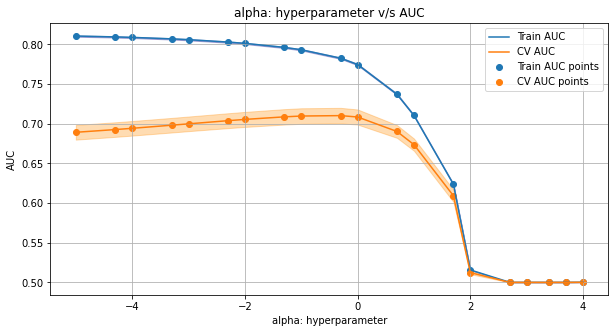

In [52]:
alphas = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]
log_alphas =[]
for a in tqdm(alphas):
    b = np.log10(a)
    log_alphas.append(b)
plt.figure(figsize=(10,5))
plt.plot(log_alphas, train_auc, label='Train AUC')
plt.gca().fill_between(log_alphas,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')
plt.plot(log_alphas, cv_auc, label='CV AUC')
plt.gca().fill_between(log_alphas,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')
plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC")
plt.grid()
plt.show()

Testing the model with best hyperparameter alpha

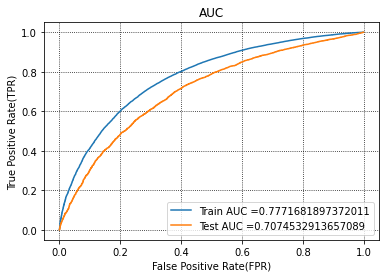

In [53]:
from sklearn.metrics import roc_curve, auc

mnb_bow_testModel = MultinomialNB(alpha = bestAlpha_1,class_prior=[0.5, 0.5])
mnb_bow_testModel.fit(x_train_onehot_bow, y_train)
y_train_pred=mnb_bow_testModel.predict_proba(x_train_onehot_bow)[:,1]
y_test_pred=mnb_bow_testModel.predict_proba(x_test_onehot_bow)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
ax = plt.subplot()
auc_set1_train=auc(train_fpr, train_tpr)
auc_set1_test=auc(test_fpr, test_tpr)
ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

Confusion Matrix

In [0]:
## confusion matrix of training data
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.5051843044820532 for threshold 0.483
[[ 9401  3833]
 [21421 52741]]
the maximum value of tpr*(1-fpr) 0.5051843044820532 for threshold 0.483


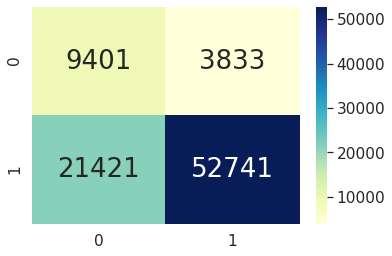

In [55]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds,train_fpr, train_tpr)), range(2),range(2))
## https://likegeeks.com/seaborn-heatmap-tutorial/#Sequential-colormap
sns.set(font_scale=1.4)
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.4336479981259221 for threshold 0.995
[[ 2898   410]
 [11925  6616]]
the maximum value of tpr*(1-fpr) 0.4336479981259221 for threshold 0.995


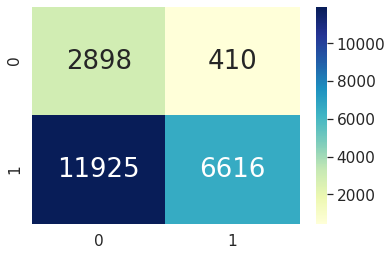

In [62]:
## test confusion matrix
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)))
conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

Applying Naive Bayes on TF-IDF and using gridsearchcv to find best alpha

In [63]:
from sklearn.model_selection import GridSearchCV
mnb_tfidf = MultinomialNB(class_prior=[0.5, 0.5])
parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}
clf = GridSearchCV(mnb_tfidf, parameters, cv= 10, scoring='roc_auc',verbose=1,return_train_score=True)
clf.fit(x_train_onehot_tfidf,y_train)
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']
bestAlpha_2=clf.best_params_['alpha']
bestScore_2=clf.best_score_
print("BEST ALPHA: ",clf.best_params_['alpha']," BEST SCORE: ",clf.best_score_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BEST ALPHA:  0.1  BEST SCORE:  0.6772790190045642


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   37.2s finished


100%|██████████| 20/20 [00:00<00:00, 22782.75it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


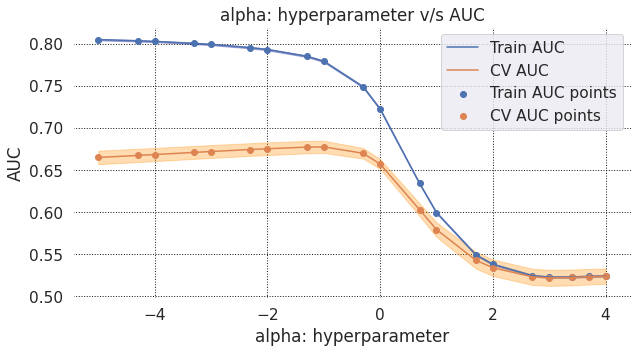

In [64]:
alphas = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]
log_alphas =[]
for a in tqdm(alphas):
    b = np.log10(a)
    log_alphas.append(b)
plt.figure(figsize=(10,5))
plt.plot(log_alphas, train_auc, label='Train AUC')
#Refrence:https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_alphas,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')
plt.plot(log_alphas, cv_auc, label='CV AUC')
plt.gca().fill_between(log_alphas,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')
ax = plt.subplot()
ax.scatter(log_alphas, train_auc, label='Train AUC points')
ax.scatter(log_alphas, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

Testing the model with best hyperparameter alpha

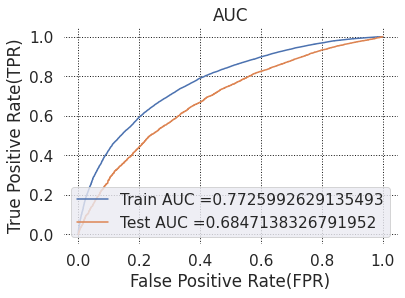

In [65]:
#https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
mnb_tfidf_testModel = MultinomialNB(alpha = bestAlpha_2,class_prior=[0.5, 0.5])
mnb_tfidf_testModel.fit(x_train_onehot_tfidf, y_train)
y_train_pred=mnb_tfidf_testModel.predict_proba(x_train_onehot_tfidf)[:,1]
y_test_pred=mnb_tfidf_testModel.predict_proba(x_test_onehot_tfidf)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
ax = plt.subplot()
auc_set2_train=auc(train_fpr, train_tpr)
auc_set2_test=auc(test_fpr, test_tpr)
ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

Confusion Matrix

In [0]:
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.49346610804198027 for threshold 0.51
[[ 9519  3715]
 [23283 50879]]
the maximum value of tpr*(1-fpr) 0.49346610804198027 for threshold 0.51


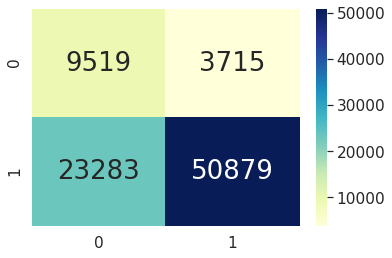

In [66]:
#training confusion matrix
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds,train_fpr, train_tpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.4071146256014726 for threshold 0.69
[[ 2807   501]
 [11751  6790]]
the maximum value of tpr*(1-fpr) 0.4071146256014726 for threshold 0.69


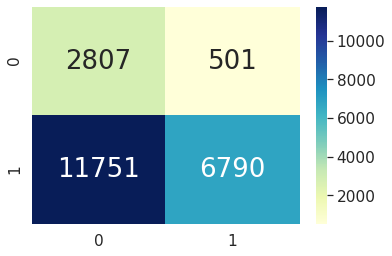

In [69]:
#test Confusion Matrix
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)))
conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 26}, fmt='g' ,cmap='YlGnBu')

Top 20 Feature based on log probablities of feature

In [0]:
feature_names_bow=[]

for i in vectorizer_sub.get_feature_names():
    feature_names_bow.append(i)   

for i in vectorizer_sub_sub.get_feature_names():
    feature_names_bow.append(i)    

for i in vectorizer_state.get_feature_names():
    feature_names_bow.append(i)    

for i in vectorizer_prefix.get_feature_names():
    feature_names_bow.append(i)   

for i in vectorizer_grade.get_feature_names():
    feature_names_bow.append(i)   

for i in vectorizer_title_bow.get_feature_names():
    feature_names_bow.append(i)    

for i in vectorizer_essay_bow.get_feature_names():
    feature_names_bow.append(i)   

feature_names_bow.append("prev_proj")


In [71]:
print(len(feature_names_bow))

18195


In [72]:
x_train_onehot_bow.shape

(87396, 18195)

In [74]:
#Refrence:https://stats.stackexchange.com/questions/266031/what-is-log-probability-of-feature-in-sklearn-multinomialnb

nb_bow=MultinomialNB(alpha=0.5,class_prior=[0.5,0.5])
nb_bow.fit(x_train_onehot_bow,y_train)
bow_features_probs = {}
for a in range(len(feature_names_bow)) :
    bow_features_probs[a] = nb_bow.feature_log_prob_[0,a]

final_bow_features = pd.DataFrame({'feature_prob_estimates' : list(bow_features_probs.values()),'feature_names' : list(feature_names_bow)})
a = final_bow_features.sort_values(by = ['feature_prob_estimates'], ascending = False)
a.head(20)

,feature_prob_estimates,feature_names
16102,-3.012105,studentsnannan
14887,-4.102839,schooled
10833,-4.427082,learningnannan
5557,-4.587219,classroomnannan
12150,-4.773021,notability
10829,-4.782189,learned
9447,-4.813617,helped
11934,-4.980866,nano
11295,-5.006347,map
12002,-5.123486,needed


Printing All The Result in Tablular Format

In [77]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameter: Alpha", "Train AUC", "Test AUC"]
x.add_row(["BOW", "Multinomial Naive Bayes", bestAlpha_1, round(auc_set1_train,2),round(auc_set1_test,2)])
x.add_row(["TF-IDF", "Multinomial Naive Bayes", bestAlpha_2, round(auc_set2_train,2),round(auc_set2_test,2)])
print(x)

+------------+-------------------------+-----------------------+-----------+----------+
| Vectorizer |          Model          | Hyperparameter: Alpha | Train AUC | Test AUC |
+------------+-------------------------+-----------------------+-----------+----------+
|    BOW     | Multinomial Naive Bayes |          0.5          |    0.78   |   0.71   |
|   TF-IDF   | Multinomial Naive Bayes |          0.1          |    0.77   |   0.68   |
+------------+-------------------------+-----------------------+-----------+----------+
